In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import re
from sklearn import svm
import matplotlib.pyplot as plt

In [2]:
scripts_path = os.path.abspath(os.path.join('../scripts'))
if scripts_path not in sys.path:
    sys.path.insert(0,scripts_path)

In [3]:
from station_location import *

In [4]:
TRAIN_SET = '../data/first-train.slist'
TEST_SET = '../data/first-test.slist'
TRUE_VALUES_SET = '../data/2018.csv'
ANTENNA_INDEX = 0
SPS_INDEX = 2
START_TIME_INDEX = 3
TIME_WINDOW = 59
WAIT_TIME_WINDOW = 1

In [5]:
# Assuming what is computed here is common to test and train
header = pd.read_csv(TRAIN_SET, sep='\t', nrows=0).columns[0].split(', ')

# Number of samples per second
sps = int(re.findall(r'\d+', header[SPS_INDEX])[0])
# Number of samples per windows
spw = (TIME_WINDOW + WAIT_TIME_WINDOW) * sps

# Antenna
antenna = header[ANTENNA_INDEX].split(' ')[1].split('_')
network = antenna[0]
station = antenna[1]
channel = antenna[3]

latitude, longitude, elevation = get_location(network, station, channel)

In [6]:
latitude, longitude, elevation

(35.79657, -97.454857, 333.0)

In [7]:
compute_distance(latitude, longitude, elevation, latitude, longitude, -5645)

5978.000000000265

In [8]:
compute_distance(latitude, longitude, elevation, 36.45094, -98.79978, -5645)

141239.64380985397

In [19]:
np.array([])

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [44]:
def gaussian_interpolation(v1, v2, nb_missing_values, mean=0, std=300, sample_freq=sps):
    x = [0, nb_missing_values]
    f_x = [v1, v2]
    missing_times = np.linspace(0, nb_missing_values - 1, nb_missing_values)
    interp_v = np.interp(missing_times, x, f_x)
    noise = np.random.normal(mean, std, nb_missing_values)
    return interp_v + noise

def load_data(data_path):
    all_dirs = !ls $data_path 
    X = np.array([])
    for d in all_dirs:
        print(f'dir {d}')
        dir_path = os.path.join(data_path+'/', d)
        first_trace_header = pd.read_csv(dir_path+'/'+'0.slist', sep='\t', nrows=0).columns[0].split(', ')
        first_start_time = pd.to_datetime(first_trace_header[START_TIME_INDEX])

        num_sample_before_dir = X.shape[0]
        dir_X = np.array([])
        all_slists = !ls $dir_path
        for slist in all_slists:
            print(f"slist {slist}")
            x_len_b = X.shape[0] #TEmp

            # Compute size of padding
            slist_full_path = os.path.join(dir_path, slist)
            header = pd.read_csv(slist_full_path, sep='\t', nrows=0).columns[0].split(', ')
            time_elapsed =  pd.to_datetime(header[START_TIME_INDEX]) - first_start_time
            num_elem_elapsed = int(time_elapsed.total_seconds()) * sps
            num_elem_padd = num_elem_elapsed - dir_X.shape[0]
            print(time_elapsed) #TEmp

            # Extract data in current file
            new_X = pd.read_csv(slist_full_path, sep='\t', header=0, names=["1", "2", "3", "4", "5", "6"])
            new_X = new_X.to_numpy().reshape(-1)
            new_X = new_X[~(np.isnan(new_X))]

            # Add interpolated padding and new data
            mean_prev = np.mean(dir_X[-100:]) if dir_X.shape[0] != 0 else 0
            mean_curr = np.mean(new_X[:100])
            gaussian_padding = gaussian_interpolation(mean_prev, mean_curr, num_elem_padd)
            dir_X = np.concatenate((dir_X,gaussian_padding))
            dir_X = np.concatenate((dir_X, new_X))
            print(x_len_b, num_elem_padd, new_X.shape[0], X.shape[0]) #TEmp
        X = np.concatenate((X, dir_X))
        print("a", X.shape[0])
        mean_prev = X[-100:]
        num_elem_padd_dir = NUM_DAY_PER_DIR*24*3600*100 - num_sample_before_dir
        X = np.concatenate((X, gaussian_interpolation(mean_prev, mean_prev, num_elem_padd_dir)))
            
    return X, first_start_time

In [45]:
!ls ../data/

2019.csv	  catalog_2017.csv  downloads	       hole_example.png
catalog_2016.csv  catalog_2018.csv  first-train.slist  olds


In [46]:
load_data('../data/downloads')

dir 1
slist 0.slist
0 days 00:00:00
0 0 2747692 0
slist 1.slist
0 days 15:39:23.980000
0 2888608 11643603 0
a 17279903
dir 2
slist 0.slist
0 days 00:00:00
17279903 0 1190042 17279903
slist 1.slist
0 days 15:41:12.820000
17279903 4457158 11632719 17279903
a 34559822
dir 3
slist 0.slist
0 days 00:00:00
34559822 0 17280001 34559822
a 51839823


(array([-2837., -2808., -2837., ..., -7903., -7926., -8074.]),
 Timestamp('2018-01-05 00:00:00'))

In [11]:
catalog = pd.read_csv(TRUE_VALUES_SET)
catalog["origintime"] = pd.to_datetime(catalog["origintime"])
catalog.sort_values("origintime", inplace=True)
catalog

,event_id,origintime,magnitude,magnitude_source,max_mmi,latitude,longitude,depth_km,err_lat,err_lon,err_depth,err_origintime,state,county,status
0,0,2018-01-01 01:43:55,2.0,OGS,0,36.880480,-97.927090,5.953,0.30,0.40,0.70,0.34,None,GRANT,None
1,0,2018-01-01 03:39:47,1.9,OGS,0,36.880650,-97.931490,5.602,0.70,0.70,1.60,0.38,None,GRANT,None
2,0,2018-01-01 04:06:26,1.9,OGS,0,36.845090,-97.703160,7.647,0.60,0.60,1.40,0.44,None,GRANT,None
3,0,2018-01-01 05:29:18,2.0,OGS,0,36.150520,-97.668760,5.000,0.30,0.40,0.80,0.35,None,LOGAN,None
4,0,2018-01-01 05:46:00,2.3,OGS,0,36.152550,-97.658960,5.345,0.30,0.30,0.80,0.39,None,LOGAN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,4412,2018-12-30 19:42:21,2.1,OGS,None,36.263050,-97.184258,3.510,4.58,2.00,2.49,0.7722337,Oklahoma,Noble,Reviewed
2678,4060,2018-12-30 23:51:51,2.0,OGS,None,36.230167,-97.939167,2.940,0.35,0.35,1.40,None,Oklahoma,Garfield,Reviewed
2679,4169,2018-12-31 07:22:29,2.6,OGS,None,35.941667,-96.728667,6.040,0.21,0.21,0.40,None,Oklahoma,Payne,Reviewed
2680,4096,2018-12-31 09:30:56,2.7,OGS,None,35.674000,-97.390000,5.860,0.14,0.14,0.40,None,Oklahoma,Oklahoma,Reviewed


In [12]:
# 2018-04-09 10:22:20
dist_1 = 49470.577600 
time_1 = 9.039
speed_1 = dist_1/time_1

# 2018-04-12 23:56:07
dist_2 = 117930.839431
time_2 = 20.283
speed_2 = dist_2/time_2

# 2018-04-11 23:37:03
dist_3 = 33191.937156
time_3 = 5.78
speed_3 = dist_3/time_3

speed_average = (speed_1 + speed_2 + speed_3)/3

#http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html
print(f"Speed 1: {speed_1}m/s")
print(f"Speed 2: {speed_2}m/s")
print(f"Speed 3: {speed_3}m/s")
print(f"Average speed: {speed_average}m/s, which is in the same order of magnitude as said here: http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html")

Speed 1: 5473.0144485009405m/s
Speed 2: 5814.270050337721m/s
Speed 3: 5742.5496809688575m/s
Average speed: 5676.611393269173m/s, which is in the same order of magnitude as said here: http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html


In [13]:
def change_time_according_to_station(catalog, lat_station, lon_station, alt_station, speed_average):
    catalog["distance"] = catalog.loc[:, ["latitude", "longitude", "depth_km"]].apply(lambda row: compute_distance(lat_station, lon_station, alt_station, row[0], row[1], -1000*row[2]), axis=1)
    catalog["time_diff"] = catalog["distance"].map(lambda dist: dist/speed_average)
    catalog["origintime"] = catalog.loc[:, ["origintime", "time_diff"]].apply(lambda row: row[0] + pd.to_timedelta(row[1], unit='s'), axis=1)

In [14]:
change_time_according_to_station(catalog, latitude, longitude, elevation, speed_average)
catalog

,event_id,origintime,magnitude,magnitude_source,max_mmi,latitude,longitude,depth_km,err_lat,err_lon,err_depth,err_origintime,state,county,status,distance,time_diff
0,0,2018-01-01 01:44:17.482678435,2.0,OGS,0,36.880480,-97.927090,5.953,0.30,0.40,0.70,0.34,None,GRANT,None,127625.428558,22.482678
1,0,2018-01-01 03:40:09.506652244,1.9,OGS,0,36.880650,-97.931490,5.602,0.70,0.70,1.60,0.38,None,GRANT,None,127761.518551,22.506652
2,0,2018-01-01 04:06:46.904160473,1.9,OGS,0,36.845090,-97.703160,7.647,0.60,0.60,1.40,0.44,None,GRANT,None,118664.795510,20.904160
3,0,2018-01-01 05:29:25.762432233,2.0,OGS,0,36.150520,-97.668760,5.000,0.30,0.40,0.80,0.35,None,LOGAN,None,44064.311252,7.762432
4,0,2018-01-01 05:46:07.738645234,2.3,OGS,0,36.152550,-97.658960,5.345,0.30,0.30,0.80,0.39,None,LOGAN,None,43929.281701,7.738645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,4412,2018-12-30 19:42:31.099859855,2.1,OGS,None,36.263050,-97.184258,3.510,4.58,2.00,2.49,0.7722337,Oklahoma,Noble,Reviewed,57332.979523,10.099860
2678,4060,2018-12-30 23:52:02.457021870,2.0,OGS,None,36.230167,-97.939167,2.940,0.35,0.35,1.40,None,Oklahoma,Garfield,Reviewed,65037.060879,11.457022
2679,4169,2018-12-31 07:22:40.943855342,2.6,OGS,None,35.941667,-96.728667,6.040,0.21,0.21,0.40,None,Oklahoma,Payne,Reviewed,67800.625312,11.943855
2680,4096,2018-12-31 09:30:58.827032528,2.7,OGS,None,35.674000,-97.390000,5.860,0.14,0.14,0.40,None,Oklahoma,Oklahoma,Reviewed,16047.965057,2.827033


In [69]:
def count_signs_per_row(X, amplitude):
    X = X - np.mean(X, axis=1).reshape(X.shape[0], 1)
    first_kernel = X[:,1:]
    second_kernel = X[:,:-1]
    change_of_sign = first_kernel * second_kernel
    
    return np.sum(change_of_sign < -amplitude, axis=1).reshape(X.shape[0], 1)

In [70]:
def weighted_sliding_mean_per_row(X, mean_size):
    N, W = X.shape
    diff = np.abs(X[:, 1:] - X[:, :-1])
    diff = diff[:, mean_size-1:]
    
    diff_sliding_mean = np.zeros((N, W - (mean_size - 1)))
    for i, w in enumerate(X):
        diff_sliding_mean[i] = np.abs(np.convolve(w, np.ones(mean_size), 'valid') / mean_size)
    weighted_diff = diff / (diff_sliding_mean[:,:-1] + 1)
    
    return np.max(weighted_diff, axis=1).reshape((N, 1))

In [71]:
def fourier_features(X, min_freq):
    # Number of samplepoints
    N = X.shape[0]

    # sample spacing
    T = 1.0 / 400
    
    X = X - np.mean(X, axis=1).reshape((N, 1))
    xf = np.fft.fft(X, axis=1)
    x_amplitudes = 2.0/N * np.abs(xf[:, :N//2])
    medians = np.median(x_amplitudes, axis=1).reshape(N, 1)
    means = np.mean(x_amplitudes[:, min_freq:], axis=1).reshape(N, 1)
    
    return np.hstack((medians, means))

In [187]:
def compute_end_time(X, start_time):
    total_number_of_seconds = (X.shape[0] - 1) / sps # First sample is at starting time -> subtract 1
    end_time = start_time + pd.to_timedelta(total_number_of_seconds, unit='s')

    return end_time

def compute_X_and_y(filename, sps, catalog, amplitude):
    X, start_time = load_data(filename)
    end_time  = compute_end_time(X, start_time)
    
    catalog = catalog[(catalog["origintime"] >= start_time) & (catalog["origintime"] <= end_time)]
    
    
    N = X.shape[0]
    window_size = TIME_WINDOW*sps
    drop_size = WAIT_TIME_WINDOW*sps
    total_window_size = window_size + drop_size    
    number_window = np.math.floor(N / total_window_size)
    X = X[:number_window*total_window_size]
    X_time_window = np.array(np.split(X.reshape(-1), number_window))
    
    y = np.zeros((X_time_window.shape[0], 1))
    
    for date in catalog["origintime"]:
        seconds_to_hq = (date - start_time).total_seconds()
        index_in_data = seconds_to_hq * sps
        index = int(index_in_data / X_time_window.shape[1])
        y[index] = 1
    
    X_time_window = X_time_window[:, drop_size:]
    
    feature1 = count_signs_per_row(X_time_window, amplitude)
    feature2 = weighted_sliding_mean_per_row(X_time_window, 25)
    feature3_4 = fourier_features(X_time_window, 30)
    
    time_stamps = pd.Series([start_time + pd.to_timedelta(i * (total_window_size / sps), unit='s') for i in range(X_time_window.shape[0])])
    
    return X_time_window, np.hstack((np.hstack((feature1, feature2)), feature3_4)), y, time_stamps.to_numpy().reshape((number_window, 1))

In [188]:
X_train_raw, X_train, y_train, time_stamps = compute_X_and_y(TRAIN_SET, sps, catalog, 100000)
X_train.shape, y_train.shape

((5760, 4), (5760, 1))

In [189]:
X_test_raw, X_test, y_test, time_stamps_test = compute_X_and_y(TEST_SET, sps, catalog, 100000)
X_test.shape, y_test.shape

((1440, 4), (1440, 1))

## Training

In [190]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

y_train[y_train==0] = -1
y_test[y_test==0] = -1
for w in [1, 5, 10, 20, 30, 50, 70]:
    clf = svm.SVC(gamma='scale', class_weight={-1: 1, 1: w})
    clf.fit(X_train, y_train.ravel())
    print("Confusion matrices for weight ", w)
    print('Precision and recall: \nPrecision:', precision_score(y_train, clf.predict(X_train)), '\nRecall: ', recall_score(y_train, clf.predict(X_train)))

Confusion matrices for weight  1
Precision and recall: 
Precision: 1.0 
Recall:  0.0666666666667
Confusion matrices for weight  5
Precision and recall: 
Precision: 1.0 
Recall:  0.1
Confusion matrices for weight  10
Precision and recall: 
Precision: 1.0 
Recall:  0.1
Confusion matrices for weight  20
Precision and recall: 
Precision: 0.266666666667 
Recall:  0.266666666667
Confusion matrices for weight  30
Precision and recall: 
Precision: 0.120481927711 
Recall:  0.333333333333
Confusion matrices for weight  50
Precision and recall: 
Precision: 0.1 
Recall:  0.333333333333
Confusion matrices for weight  70
Precision and recall: 
Precision: 0.0833333333333 
Recall:  0.4


## Little manual checks

In [191]:
eq_train = pd.DataFrame(X_train[np.where(y_train==1)[0], :])
neq_train = pd.DataFrame(X_train[np.where(y_train==-1)[0], :][:20])
display(eq_train.head())
display(neq_train.head())
display(eq_train.describe())
neq_train.describe()

,0,1,2,3
0,43.0,0.246500,2.198524,2.425714
1,30.0,0.222386,2.790457,4.254126
2,779.0,5.186361,30.214384,80.674363
3,17.0,0.144926,3.160512,4.889970
4,351.0,2309.842520,297.068534,1129.140951


,0,1,2,3
0,5.0,0.123460,1.137181,1.367214
1,45.0,0.251359,1.587115,2.861155
2,5.0,0.167504,0.934057,1.391702
3,4.0,0.198105,0.839145,1.356573
4,13.0,0.418316,1.332278,1.885573


,0,1,2,3
count,30.000000,30.000000,30.000000,30.000000
mean,116.033333,85.348814,14.850302,46.722607
std,160.117518,422.290958,53.570268,204.941314
min,1.000000,0.085553,1.624397,2.205248
25%,27.000000,0.186978,2.664062,3.993290
50%,56.500000,0.340079,3.679564,4.934012
75%,167.000000,0.548765,5.194542,9.014124
max,779.000000,2309.842520,297.068534,1129.140951


,0,1,2,3
count,20.000000,20.000000,20.000000,20.000000
mean,25.800000,0.374325,1.930144,3.034960
std,39.414932,0.449021,1.600071,2.010783
min,0.000000,0.047926,0.661497,1.057916
25%,3.750000,0.150343,1.100877,1.802803
50%,7.000000,0.193208,1.343935,2.519334
75%,31.750000,0.310370,1.977584,3.288964
max,144.000000,1.647922,6.432860,8.526148


In [205]:
earthquake_times = time_stamps[y_train == 1]
earthquake_indices = np.where(y_train == 1)[0]
not_earthquake_times = time_stamps[y_train == -1]
not_earthquake_indices =  np.where(y_train == -1)[0]

In [158]:
time_hq = pd.to_datetime("2018-04-09 10:22:18")
second_to_hq = (time_hq - start_time_train).total_seconds()

time_window_hq = X_trai[int(second_to_hq * sps): int(second_to_hq * sps) + spw]
time_window_hq = time_window_hq - np.mean(time_window_hq)

In [206]:
start_time_train = pd.to_datetime("2018-04-09 00:00:00")

def get_window_timestamp(date):
    seconds_to_hq = (pd.to_datetime(date) - start_time_train).total_seconds()
    
    time_window = X_train[int(seconds_to_hq * sps / spw), :]
    
    return time_window

def plot_window_time_and_fft(time_window, date, data_index, earthquake, stats, i):
    print("Features: ", X_train[data_index])
    # Number of samplepoints
    N = 600

    # sample spacing
    T = 1.0 / 400

    x = np.arange(np.shape(time_window)[0])
    y = time_window - np.mean(time_window)

    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = np.fft.fft(y)
    y_amplitudes = 2.0/N * np.abs(yf[:N//2])

    _, axs = plt.subplots(ncols=2, figsize=(20,8))
    title = "Earthquake time window" if earthquake else "Not earthquake time window"
    plt.suptitle(title, fontsize=18)
    
    # Plot time
    axs[0].plot(x, y)
    axs[0].set_title("Time plot for time window", fontsize=18)
    axs[0].set_xlabel("Time", fontsize=13)
    axs[0].set_ylabel("Value", fontsize=13)
    
    # Plot frequency
    axs[1].plot(xf, 2.0/N * np.abs(yf[:N//2]))
    axs[1].set_title("FFT plot for time window", fontsize=18)
    axs[1].set_xlabel("Frequency", fontsize=13)
    axs[1].set_ylabel("Amplitude", fontsize=13)
    
    plt.show() 

Features:  [ 70.           0.20761474   3.44452257   4.32000221]


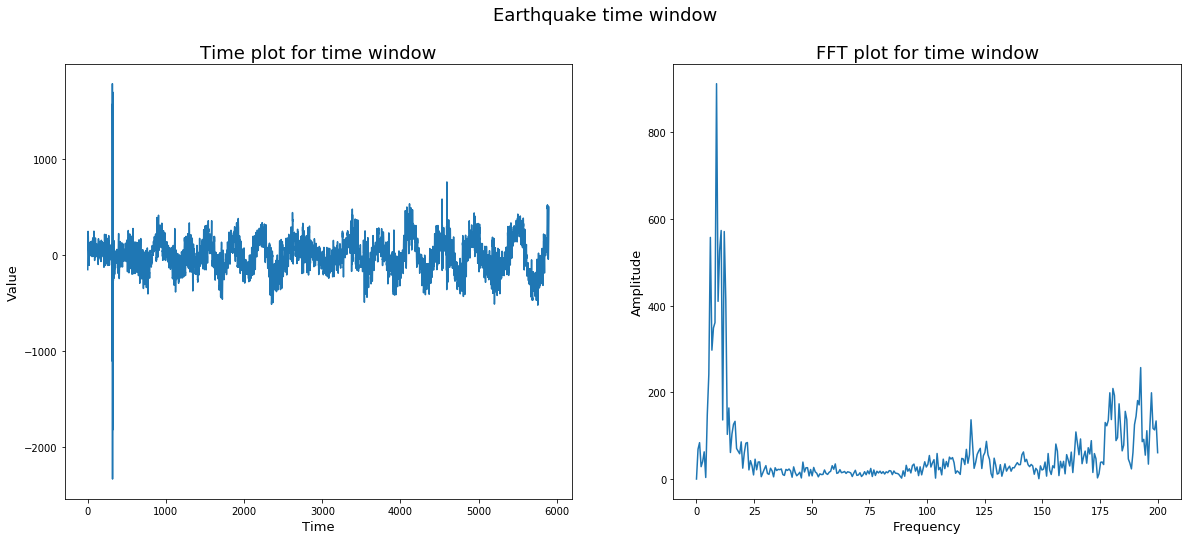

Features:  [ 102.            2.17395365    4.01018515    4.90734542]


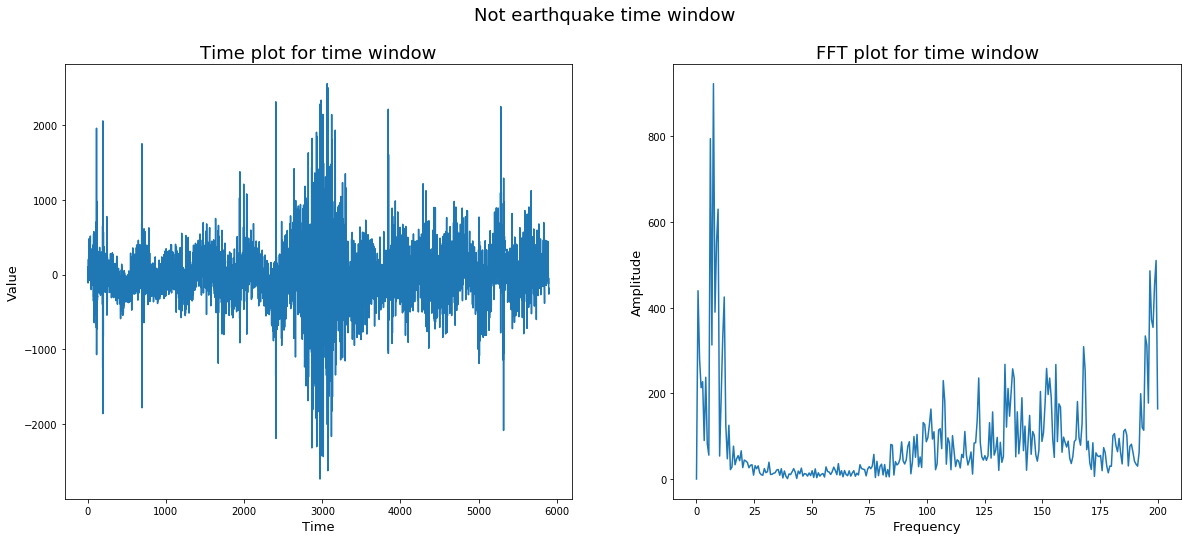

Features:  [ 182.            0.28482176    5.65553519    8.15947444]


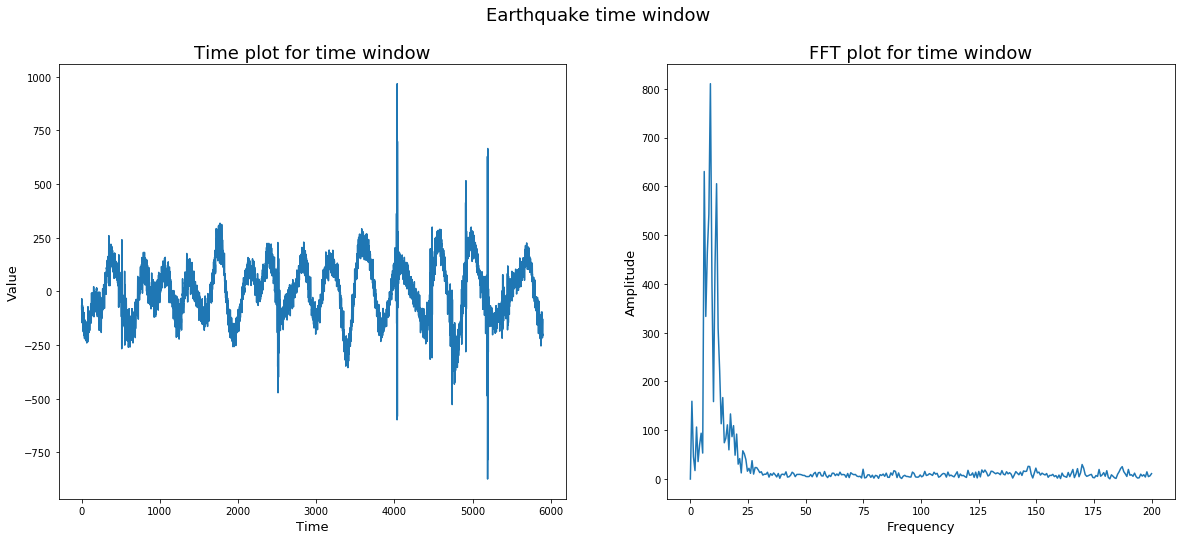

Features:  [ 7.          0.24135877  1.22685005  1.44217461]


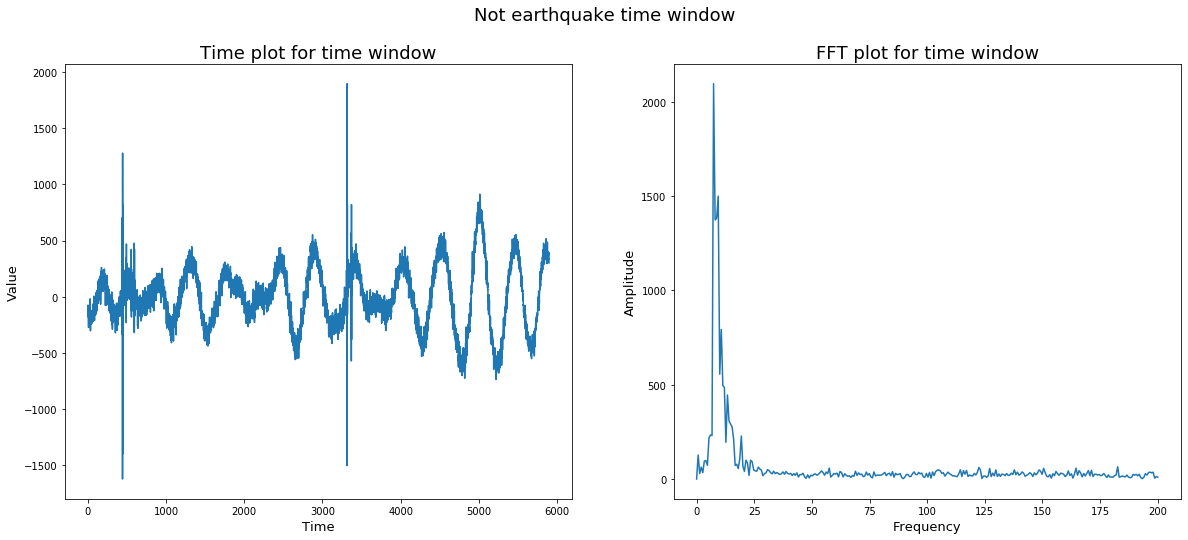

Features:  [ 26.           0.54899925   3.62527221   4.28841064]


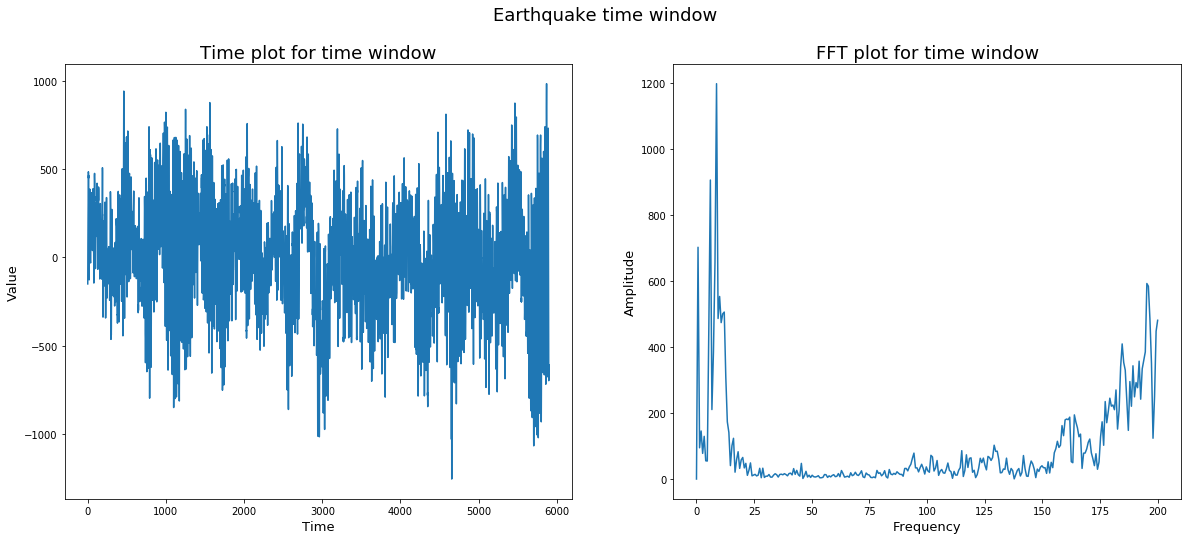

Features:  [ 0.          0.0759746   1.66293417  2.12958964]


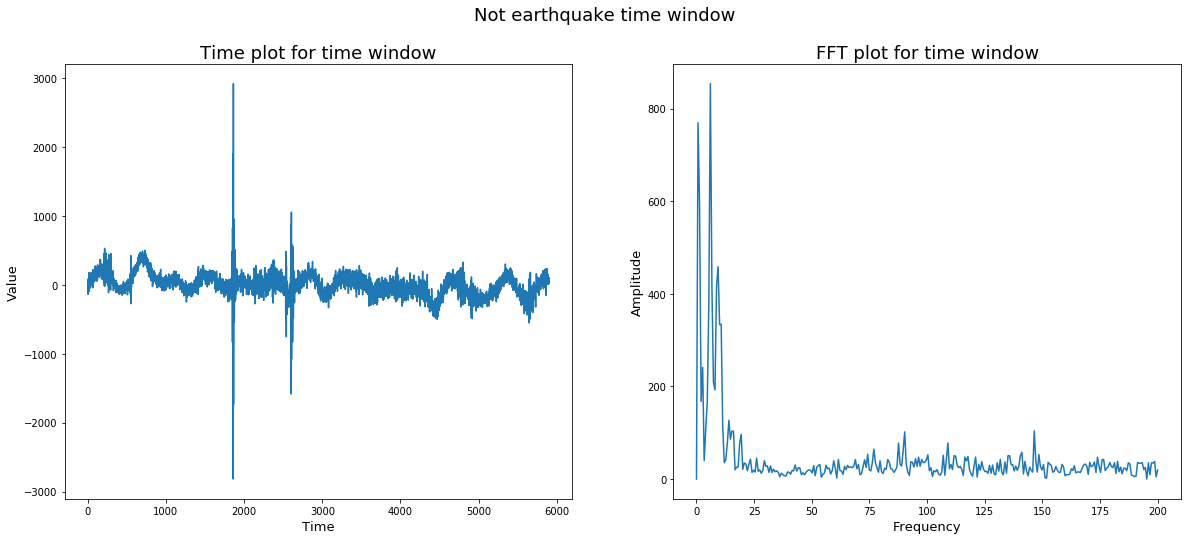

Features:  [ 395.            3.20083843   10.62970666   22.58045414]


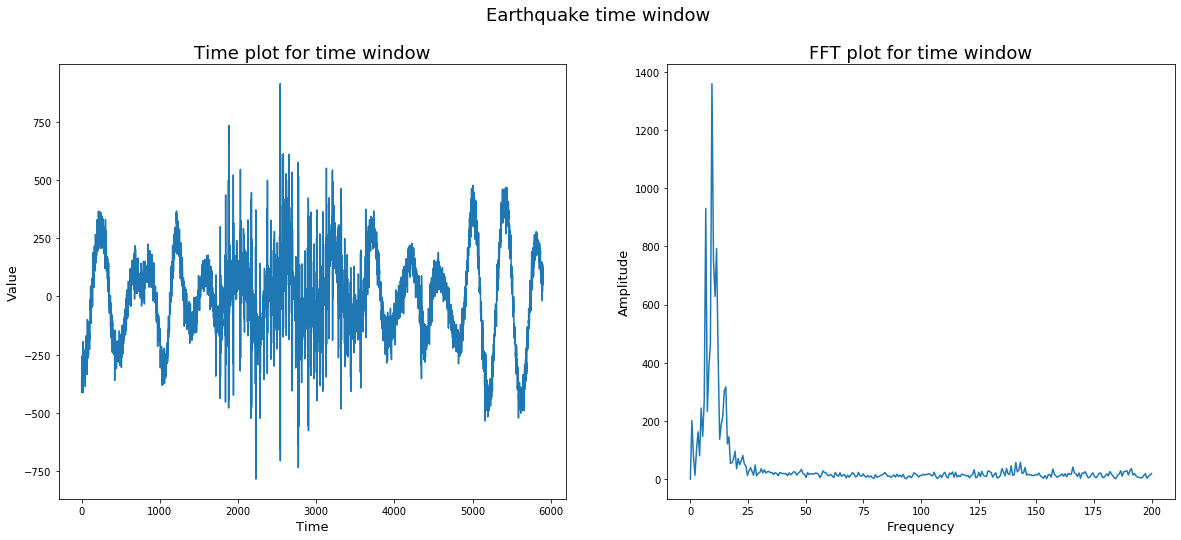

Features:  [ 17.           0.97307887   1.99931034   2.36797518]


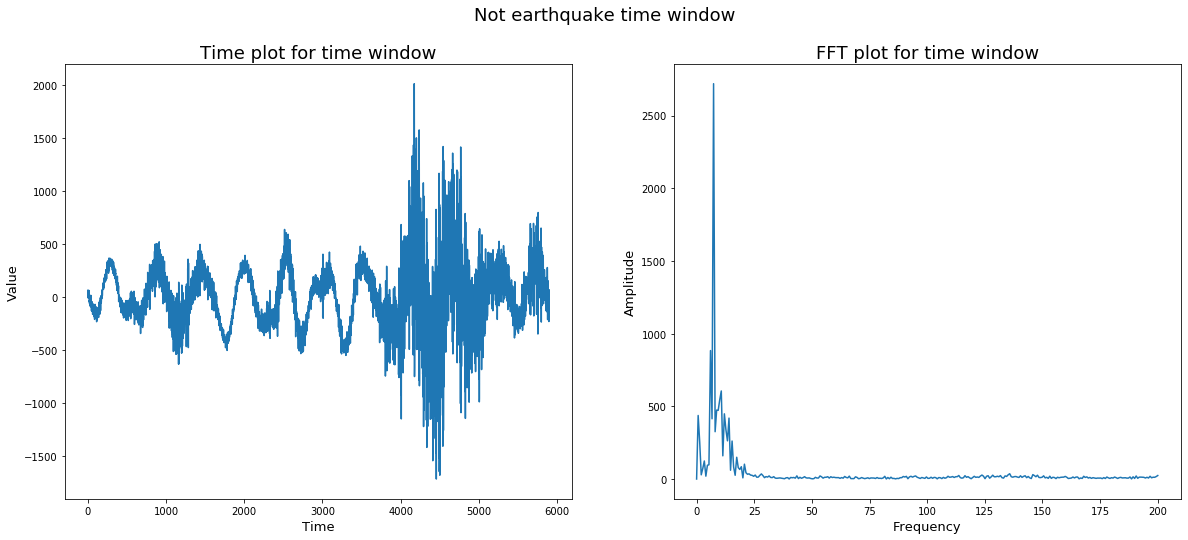

Features:  [ 43.           0.24650039   2.19852404   2.42571434]


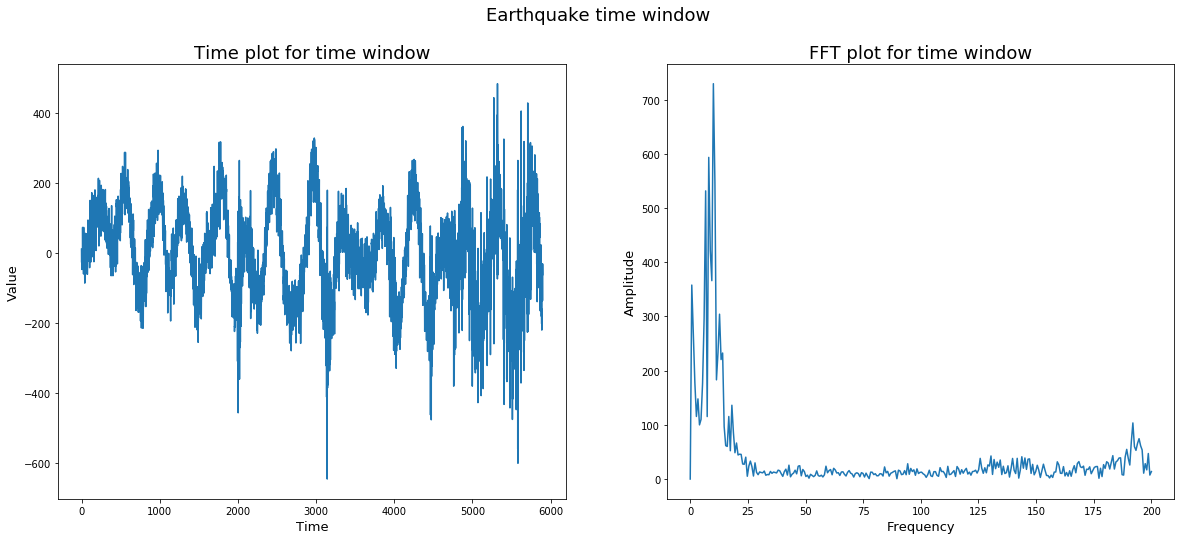

Features:  [ 44.           0.30610549   0.74489426   1.56527144]


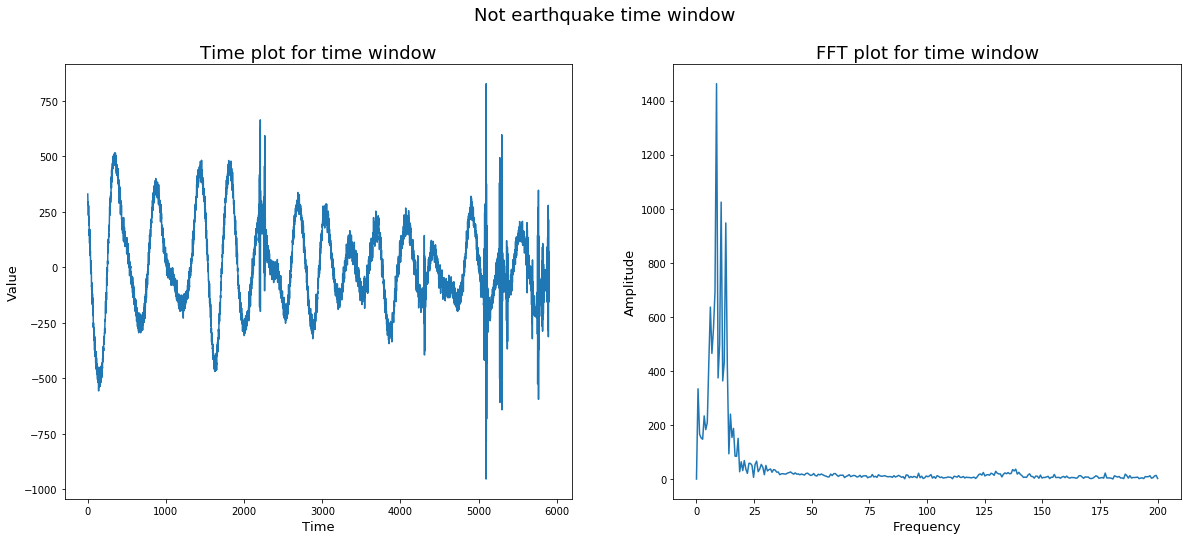

Features:  [ 36.           0.59041329   3.73385507   4.46361247]


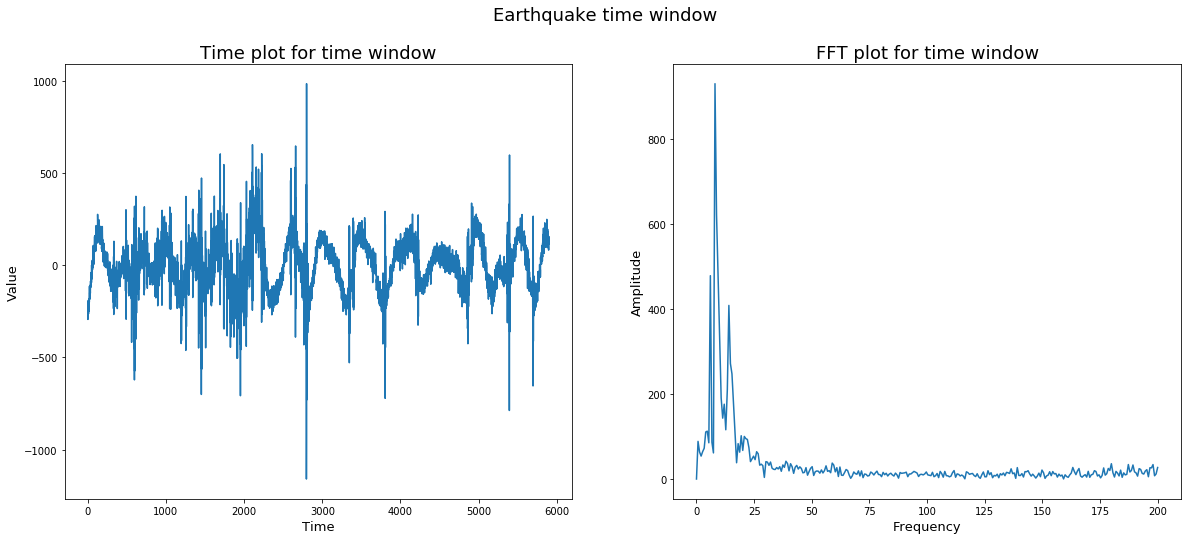

Features:  [ 18.           0.20869869   1.9311959    2.19223136]


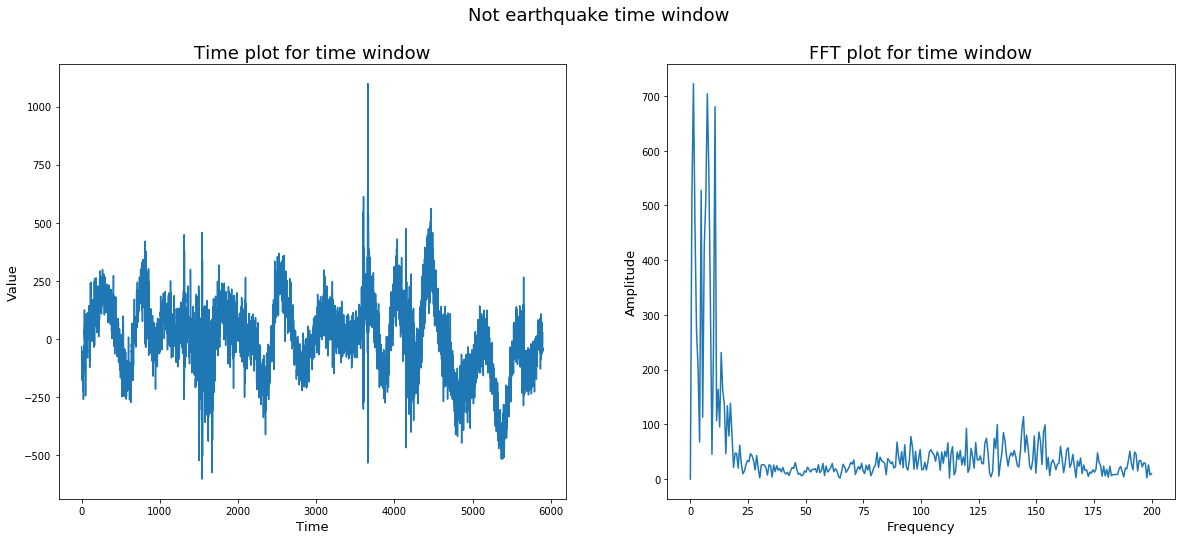

Features:  [ 40.           0.54806266   3.76216153   4.33401928]


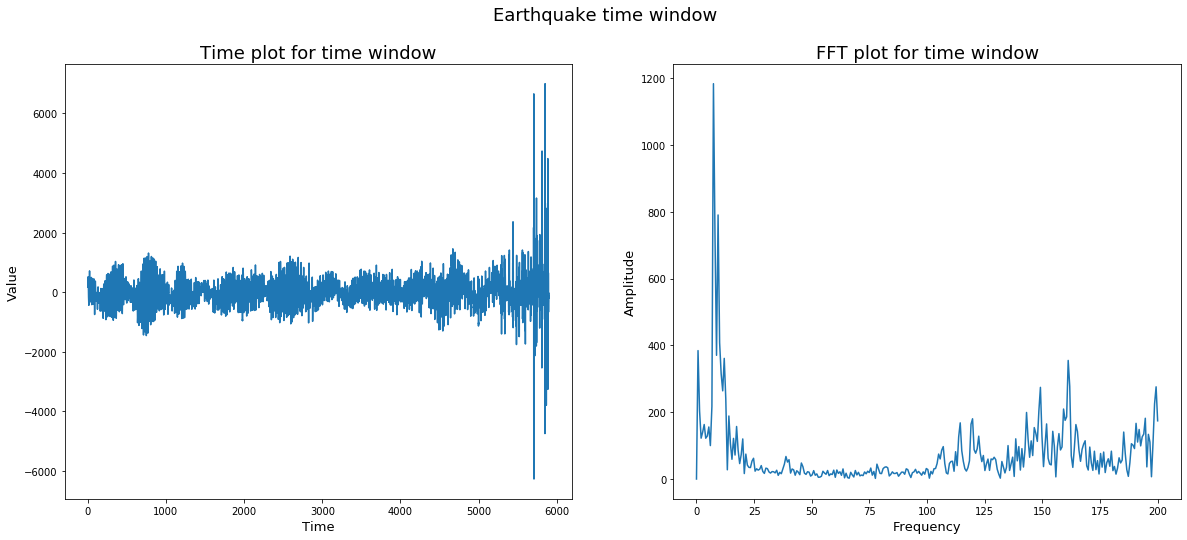

Features:  [ 25.           0.21765819   1.50801198   2.01533081]


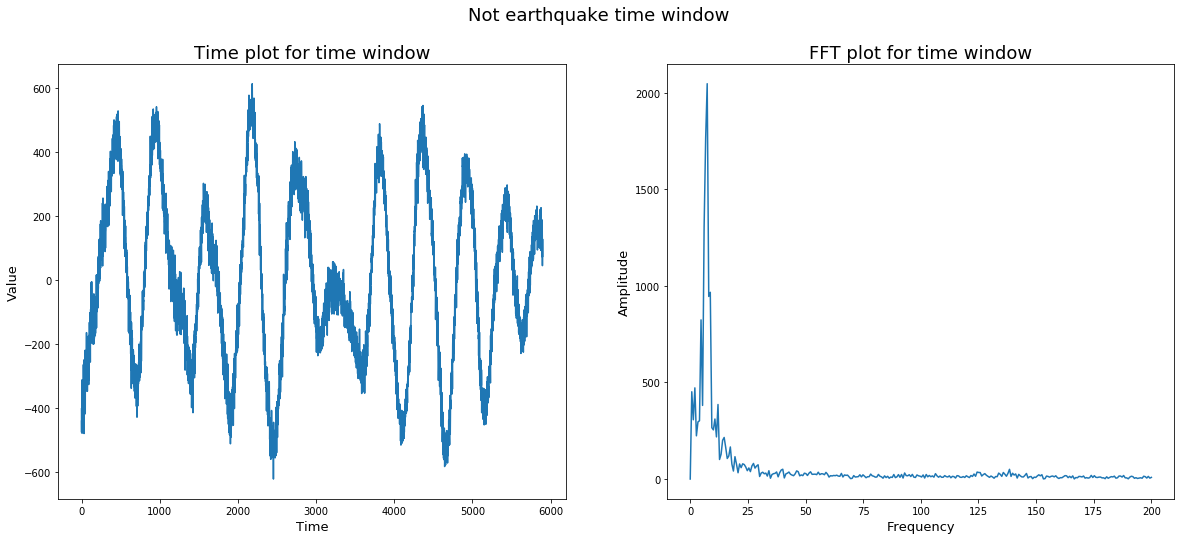

In [208]:
nm_plots = 7

eqs = np.random.choice(len(earthquake_times), nm_plots, replace=False)
not_eqs = np.random.choice(len(not_earthquake_times), nm_plots, replace=False)

stats = pd.DataFrame()
for i, (eq, not_eq) in enumerate(list(zip(eqs, not_eqs))):
    plot_window_time_and_fft(X_train_raw[eq], earthquake_times[eq], earthquake_indices[eq], True, stats, i)
    plot_window_time_and_fft(X_train_raw[not_eq], not_earthquake_times[not_eq], not_earthquake_indices[not_eq], False, stats, i+1000)
